In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots
from sklearn.metrics import mean_squared_error

#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [6]:
ts = pd.read_csv('../data/PJMW_hourly.csv', index_col=[0], parse_dates=[0])

In [7]:
ts.head()

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077.0
2002-12-31 02:00:00,4939.0
2002-12-31 03:00:00,4885.0
2002-12-31 04:00:00,4857.0
2002-12-31 05:00:00,4930.0


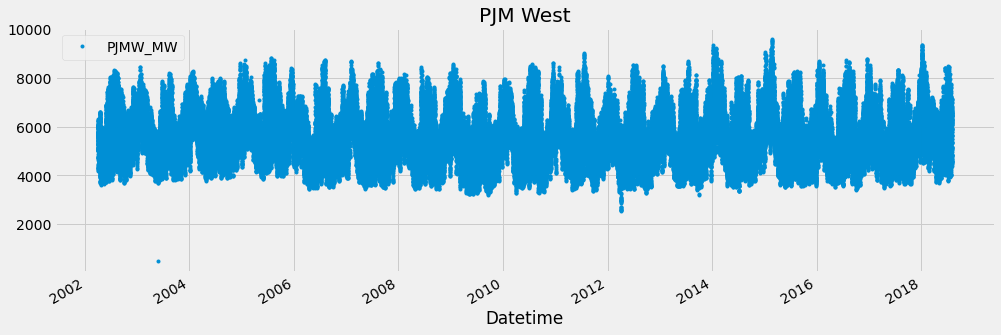

In [13]:
ts.plot(style='.', figsize=(15,5), title='PJM West')
plt.show()

In [11]:
# find the index which allows us to split off 20% of the data
split_date = '01-Jan-2015'
train = ts.loc[ts.index <= split_date].copy()
test = ts.loc[ts.index > split_date].copy()

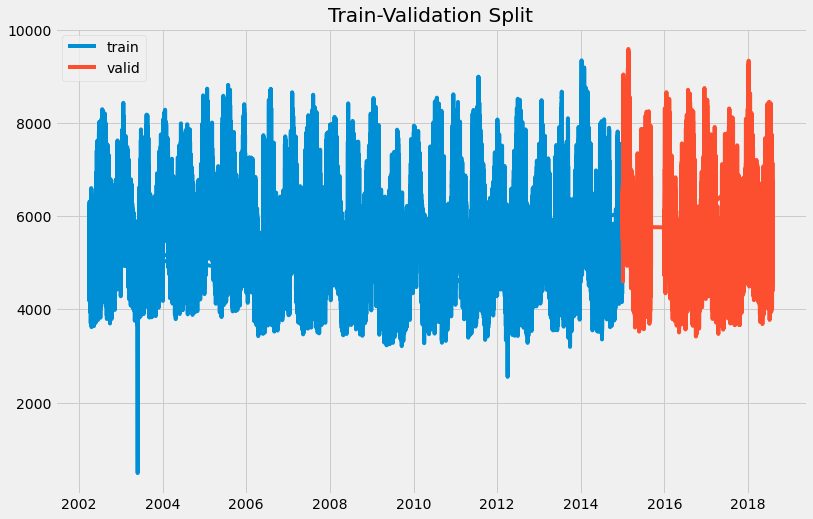

In [12]:
# Define train and test sets according to the index found above

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train, label='train')
ax.plot(valid, label='valid')
ax.set_title('Train-Validation Split');
plt.legend()

## Baseline

In [16]:
naive = train.shift(1)
naive

,PJMW_MW
Datetime,
2002-12-31 01:00:00,NaN
2002-12-31 02:00:00,5077.0
2002-12-31 03:00:00,4939.0
2002-12-31 04:00:00,4885.0
2002-12-31 05:00:00,4857.0
...,...
2014-01-01 20:00:00,6377.0
2014-01-01 21:00:00,6371.0
2014-01-01 22:00:00,6378.0


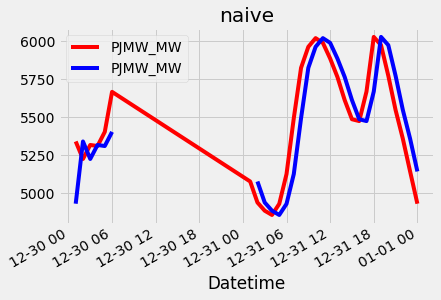

In [17]:
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

In [18]:
np.sqrt(mean_squared_error(train[1:], naive.dropna()))

246.41837117700075

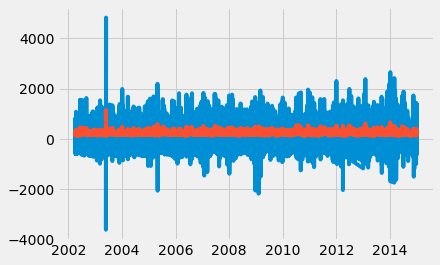

In [19]:
fig, ax = plt.subplots()
residuals = naive[1:] - train[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

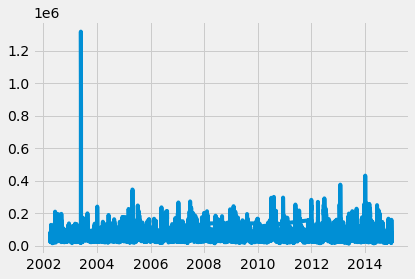

In [20]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

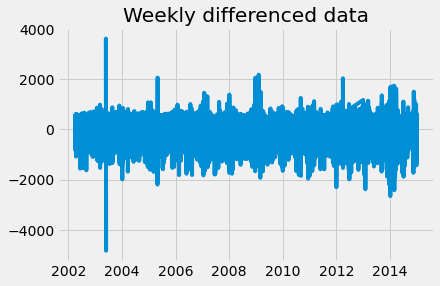

In [21]:
fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title('Weekly differenced data');

### Autoregressive Model

In [22]:
ar_1 = ARIMA(train, order=(1, 1, 0)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packag

Datetime
2002-12-31 01:00:00       0.000000
2002-12-31 02:00:00    5259.997828
2002-12-31 03:00:00    4852.110458
2002-12-31 04:00:00    4850.999744
2002-12-31 05:00:00    4839.370238
                          ...     
2014-01-01 20:00:00    6487.186013
2014-01-01 21:00:00    6367.222194
2014-01-01 22:00:00    6382.407441
2014-01-01 23:00:00    6094.443621
2014-01-02 00:00:00    5703.702251
Name: predicted_mean, Length: 111767, dtype: float64

In [23]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                PJMW_MW   No. Observations:               111767
Model:                 ARIMA(1, 1, 0)   Log Likelihood             -745873.460
Date:                Fri, 13 Aug 2021   AIC                        1491750.921
Time:                        14:24:09   BIC                        1491770.169
Sample:                             0   HQIC                       1491756.733
                             - 111767                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6296      0.001    647.003      0.000       0.628       0.632
sigma2      3.665e+04     50.842    720.863      0.000    3.66e+04    3.67e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):           3161896.86
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
random_walk_model = ARIMA(train, order=(0, 1, 0)).fit()
random_walk_model.summary()

/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packag

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                PJMW_MW   No. Observations:               111767
Model:                 ARIMA(0, 1, 0)   Log Likelihood             -774087.887
Date:                Fri, 13 Aug 2021   AIC                        1548177.774
Time:                        14:25:28   BIC                        1548187.398
Sample:                             0   HQIC                       1548180.680
                             - 111767                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.072e+04    128.574    472.270      0.000    6.05e+04     6.1e+04
===================================================================================
Ljung-Box (L1) (Q):               44308.32   Jarque-Bera (JB):            174734.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.66
Prob(H) (two-sided):                  0.10   Kurtosis:                         8.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
print(f'Random Walk AIC: {random_walk_model.aic}')
print(f'AR(1, 1, 0) AIC: {ar_1.aic}' )

Random Walk AIC: 1548177.7741394849
AR(1, 1, 0) AIC: 1491750.9208361458


In [27]:
y_hat_ar1 = ar_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

192.0437904993296

In [28]:
y_hat_rw = random_walk_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_rw))

246.88477547590568

In [29]:
ar_2 = ARIMA(train, order=(2, 1, 0)).fit()

ar_2.predict(typ='levels')

/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packag

Datetime
2002-12-31 01:00:00       0.000000
2002-12-31 02:00:00    5259.995198
2002-12-31 03:00:00    4851.585423
2002-12-31 04:00:00    4851.299673
2002-12-31 05:00:00    4839.475185
                          ...     
2014-01-01 20:00:00    6486.128244
2014-01-01 21:00:00    6366.707238
2014-01-01 22:00:00    6382.437376
2014-01-01 23:00:00    6094.108969
2014-01-02 00:00:00    5703.648610
Name: predicted_mean, Length: 111767, dtype: float64

In [30]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)

1548177.7741394849
1491750.9208361458
1491751.9883563635


### Moving Average Model

In [31]:
ma_1 = ARIMA(train, order=(0, 0, 1)).fit()
y_hat = ma_1.predict(typ='levels')
y_hat

/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packag

Datetime
2002-12-31 01:00:00    5599.559234
2002-12-31 02:00:00    5339.546958
2002-12-31 03:00:00    5334.677632
2002-12-31 04:00:00    5266.081455
2002-12-31 05:00:00    5276.979304
                          ...     
2014-01-01 20:00:00    5791.051124
2014-01-01 21:00:00    6125.004736
2014-01-01 22:00:00    5828.778100
2014-01-01 23:00:00    5939.517923
2014-01-02 00:00:00    5561.037130
Name: predicted_mean, Length: 111767, dtype: float64

In [32]:
ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                PJMW_MW   No. Observations:               111767
Model:                 ARIMA(0, 0, 1)   Log Likelihood             -860055.984
Date:                Fri, 13 Aug 2021   AIC                        1720117.968
Time:                        14:29:31   BIC                        1720146.840
Sample:                             0   HQIC                       1720126.686
                             - 111767                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5599.5592      3.061   1829.236      0.000    5593.559    5605.559
ma.L1          0.9060      0.001    810.612      0.000       0.904       0.908
sigma2      2.828e+05   1227.792    230.318      0.000     2.8e+05    2.85e+05
===================================================================================
Ljung-Box (L1) (Q):               73619.04   Jarque-Bera (JB):               552.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)

1548177.7741394849
1491750.9208361458
1491751.9883563635
1720117.9677224474


In [34]:
y_hat_ar1 = ma_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

531.7308665143644

In [35]:
ma_2 = ARIMA(train, order=(0, 1, 2)).fit()
y_hat = ma_2.predict(typ='levels')
y_hat

/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packag

Datetime
2002-12-31 01:00:00       0.000000
2002-12-31 02:00:00    5218.615273
2002-12-31 03:00:00    4845.377217
2002-12-31 04:00:00    4847.658802
2002-12-31 05:00:00    4874.288136
                          ...     
2014-01-01 20:00:00    6434.055300
2014-01-01 21:00:00    6305.820855
2014-01-01 22:00:00    6401.149501
2014-01-01 23:00:00    6109.886943
2014-01-02 00:00:00    5710.461113
Name: predicted_mean, Length: 111767, dtype: float64

In [36]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)

1548177.7741394849
1491750.9208361458
1491751.9883563635
1720117.9677224474
1496055.91658649


### ARMA

In [37]:
arma_21 = ARIMA(train, order=(2, 1, 2)).fit()

/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/ryanreilly/opt/anaconda3/envs/learn-env/lib/python3.8/site-packag

In [38]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)
print(arma_21.aic)

1548177.7741394849
1491750.9208361458
1491751.9883563635
1720117.9677224474
1496055.91658649
1475890.654442621


In [39]:
def find_rmse(model, train_data=train):
    y_hat = model.predict(typ='levels')
    return np.sqrt(mean_squared_error(train_data, y_hat))

In [40]:
print(find_rmse(random_walk_model))
print(find_rmse(ar_1))
print(find_rmse(ar_2))
print(find_rmse(ma_1))
print(find_rmse(ma_2))
print(find_rmse(arma_21))

246.88477547590568
192.0437904993296
192.04299437123626
531.7308665143644
195.7529882750948
178.9700634111403


In [47]:
def find_rmse_test(model, test_data=test):
    y_hat = model.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')
    return np.sqrt(mean_squared_error(test_data, y_hat))

In [48]:
print(find_rmse_test(random_walk_model))
print(find_rmse_test(ar_1))
print(find_rmse_test(ar_2))
print(find_rmse_test(ma_1))
print(find_rmse_test(ma_2))
print(find_rmse_test(arma_21))

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'